In [2]:
import matplotlib
matplotlib.use('Agg')

% matplotlib inline

# homebrewed modules
from metro import multiplex as mx
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data
from metro import ita

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import random                   # randomly sample node subsets
import matplotlib.pyplot as plt # convenience for plotting

from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import igraph
import pandas as pd
import matplotlib.cm as cm
import copy


In [3]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

multi.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

In [7]:
multi.summary()

OD: loaded

layer           	nodes 	edges
----------------------------------------
metro--streets   	0 	234
taz              	4243 	0
streets          	10728 	21508
taz--streets     	0 	8486
metro            	117 	250


In [98]:
len(multi.G.nodes()), len(multi.G.edges())

(15088, 30478)

In [22]:
o_demand = {key : sum(multi.od[key].values()) for key in multi.od}
nx.set_node_attributes(multi.G, 'o_demand', 0)
nx.set_node_attributes(multi.G, 'o_demand', o_demand)

In [89]:
M = multi.layers_as_subgraph(['metro'])
S = multi.layers_as_subgraph(['streets'])
T = multi.layers_as_subgraph(['taz'])

S_M = multi.layers_as_subgraph(['metro', 'streets'])
rm_edges = [e for e in S_M.edges_iter() if S_M.edge[e[0]][e[1]]['layer'] != 'metro--streets']
S_M.remove_edges_from(rm_edges)

S_T = multi.layers_as_subgraph(['taz', 'streets'])
rm_edges = [e for e in S_T.edges_iter() if S_T.edge[e[0]][e[1]]['layer'] != 'taz--streets']
S_T.remove_edges_from(rm_edges)

rm_nodes = [n for n in S_M.nodes() if len(S_M.predecessors(n)) + len(S_M.successors(n)) == 0]
S_M.remove_nodes_from(rm_nodes)
# S_M = multi.layers_as_subgraph(['metro--streets'])
# S_T = multi.layers_as_subgraph(['taz--streets'])


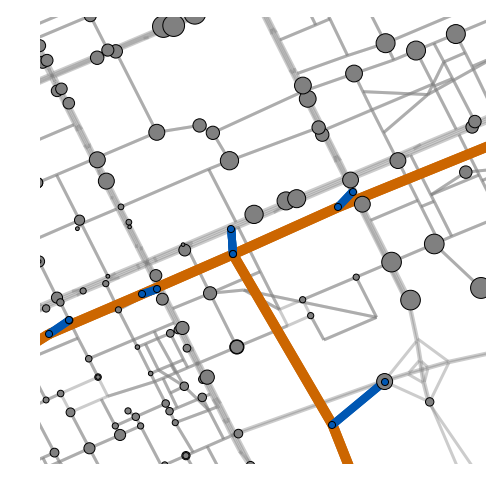

In [93]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)


center_point = (46.6967, 24.6933)
l = .02

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

ax.set(xlim = xlim, ylim = ylim)

nx.draw(S,
        viz.get_coords(S),
        edge_color = 'grey', 
        width = 3,
        node_color = 'white',
        node_size = 0,
        alpha = .4,
        with_labels = False,
        arrows = False)

nx.draw(M,
        viz.get_coords(M),
        edge_color = '#cc6600', 
        width = 10,
        node_color = '#0057b3',
        node_size = 0,
        alpha = 1,
        with_labels = False,
        arrows = False)

T.size = [T.node[t]['o_demand'] * .3 for t in T.node]
nx.draw(T,
        viz.get_coords(T),
        node_size = T.size,
        width = 3,
        node_color = 'grey',
        alpha = 1,
        with_labels = False,
        arrows = False)

nx.draw(S_M,
        viz.get_coords(S_M),
        edge_color = '#0057b3', 
        width = 8,
        node_color = '#0057b3',
        node_size = 50,
        alpha = 1,
        with_labels = False,
        arrows = False)

# fig.set_facecolor("#000000")
plt.savefig('4_figs/mx_structure')

In [99]:
dists = nx.get_edge_attributes(multi.G, 'dist_km')
times = nx.get_edge_attributes(multi.G, 'free_flow_time_m')

speed_km_m = {key : dists[key]/times[key] for key in dists}

nx.set_edge_attributes(multi.G, 'speed_km_m', speed_km_m)

street_speed = multi.mean_edge_attr_per(layers = ['streets'], 
                                    attr = 'speed_km_m', 
                                    weight_attr = 'dist_km')

In [102]:
street_speed * 60 # mean street velocity

37.989156146453723

In [96]:
len(multi.G.edges())

30478